In [4]:
import numpy as np
import pandas as pd
import cv2
import os
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Lambda
from tensorflow.keras.optimizers import Adam
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"

df = pd.read_csv(CSV_PATH)
print(f"Dataset contains {len(df)} entries")
print(df.head())

image_data = []
labels = []
valid_indices = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['image_idx'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128)) 
            image_data.append(img)
            labels.append(row['blood(mg/dL)'])
            valid_indices.append(idx)

image_data = np.array(image_data)
labels = np.array(labels)
print(f"\nSuccessfully loaded {len(image_data)} images")

Dataset contains 2235 entries
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment  
0           3.9          0  
1           3.9          0  
2           3.9          0  
3          12.2          0  
4          12.2          0  

Successfully loaded 2235 images


In [5]:
def white_balance(img):
    avg_b = np.mean(img[:,:,0])
    avg_g = np.mean(img[:,:,1])
    avg_r = np.mean(img[:,:,2])
    avg_gray = (avg_b + avg_g + avg_r) / 3
    img[:,:,0] = np.minimum(img[:,:,0] * (avg_gray / avg_b), 255)
    img[:,:,1] = np.minimum(img[:,:,1] * (avg_gray / avg_g), 255)
    img[:,:,2] = np.minimum(img[:,:,2] * (avg_gray / avg_r), 255)
    return img.astype(np.uint8)

def crop_center(img, fraction=0.4):
    h, w = img.shape[:2]
    ch, cw = int(h * fraction), int(w * fraction)
    start_x, start_y = (w - cw) // 2, (h - ch) // 2
    return img[start_y:start_y+ch, start_x:start_x+cw]

def extract_color_features(skin_img):
    features = {}
    b, g, r = cv2.split(skin_img)
    features['rgb'] = [r, g, b]
    hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    features['hsv'] = [h, s, v]
    return features

def extract_pixel_statistics(channel):
    mask = channel > 0
    if np.sum(mask) == 0:
        return np.zeros(8)
    pixels = channel[mask]
    return np.array([
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels),
        np.median(pixels),
        np.percentile(pixels, 25),
        np.percentile(pixels, 75),
        np.max(pixels) - np.min(pixels)
    ])

def preprocess_images_dual(images):
    rgb_features_all = []
    hsv_features_all = []
    for img in images:
        balanced = white_balance(img)
        skin = crop_center(balanced)
        color_features = extract_color_features(skin)
        rgb_stats = []
        hsv_stats = []
        for channel in color_features['rgb']:
            rgb_stats.extend(extract_pixel_statistics(channel))
        for channel in color_features['hsv']:
            hsv_stats.extend(extract_pixel_statistics(channel))
        rgb_features_all.append(rgb_stats)
        hsv_features_all.append(hsv_stats)
    return np.array(rgb_features_all), np.array(hsv_features_all)

In [6]:
def build_dual_branch_1dcnn(input_shape=(24, 1)):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    hsv_input = Input(shape=input_shape, name='hsv_input')

    def branch_block(input_tensor):
        x = Conv1D(32, 3, padding='same', activation='relu')(input_tensor)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(64, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(128, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(128, 3, padding='same', activation='relu')(x)
        x = MaxPooling1D(2, padding='same')(x)
        return Flatten()(x)

    rgb_branch = branch_block(rgb_input)
    hsv_branch = branch_block(hsv_input)

    merged = concatenate([rgb_branch, hsv_branch])
    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(delta=1.0),
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [15]:
# Scale the features first
scaler_rgb = MinMaxScaler()
scaler_hsv = MinMaxScaler()
rgb_features, hsv_features = preprocess_images_dual(image_data)
y = labels
rgb_features_scaled = scaler_rgb.fit_transform(rgb_features)
hsv_features_scaled = scaler_hsv.fit_transform(hsv_features)

# Reshape the features
rgb_features_reshaped = rgb_features_scaled.reshape(-1, 24, 1)
hsv_features_reshaped = hsv_features_scaled.reshape(-1, 24, 1)

# Now perform the splits
rgb_train, rgb_test, hsv_train, hsv_test, y_train, y_test = train_test_split(
    rgb_features_reshaped, hsv_features_reshaped, y, test_size=0.2, random_state=42)

rgb_train, rgb_val, hsv_train, hsv_val, y_train, y_val = train_test_split(
    rgb_train, hsv_train, y_train, test_size=0.125, random_state=42)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model = build_dual_branch_1dcnn(input_shape=(24, 1))
model.summary()
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
]
history=model.fit(
    {'rgb_input': rgb_train, 'hsv_input': hsv_train},
    y_train,
    validation_data=({'rgb_input': rgb_val, 'hsv_input': hsv_val}, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 24, 32)               128       ['rgb_input[0][0]']           
                                                                                                  
 conv1d_12 (Conv1D)          (None, 24, 32)               128       ['hsv_input[0][0]']           
                                                                                            

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict([rgb_test, hsv_test]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

14/14 [==============================] - 0s 2ms/step

Test Results:
RMSE: 3.06
MAE: 2.37
R²: 0.68


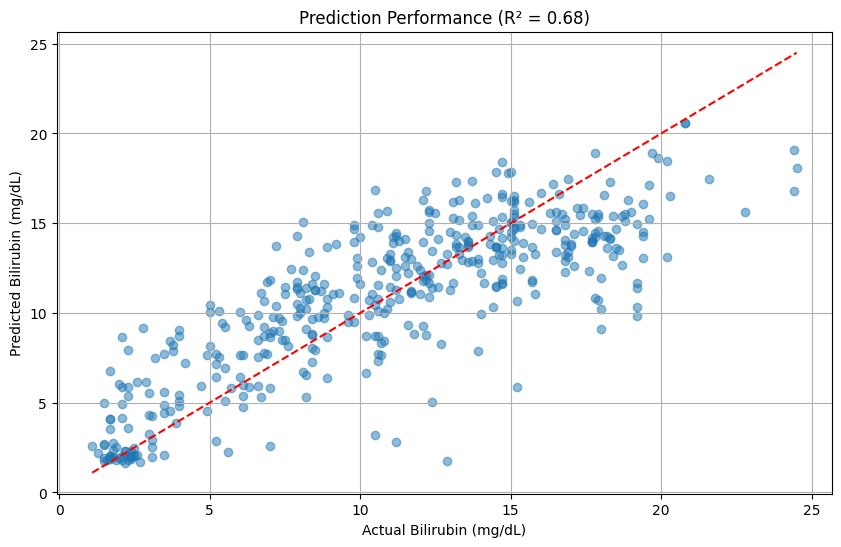

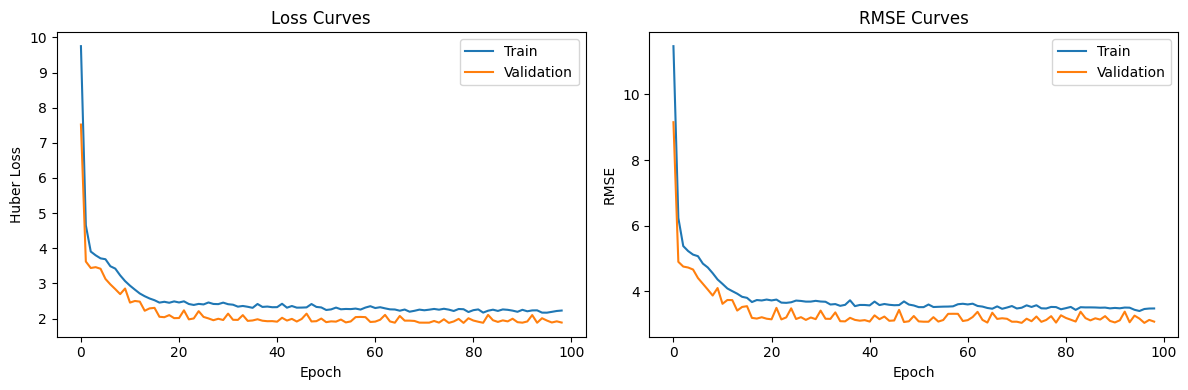

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.show()

# --- Plot Training History ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'], label='Train')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
plt.title('RMSE Curves')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

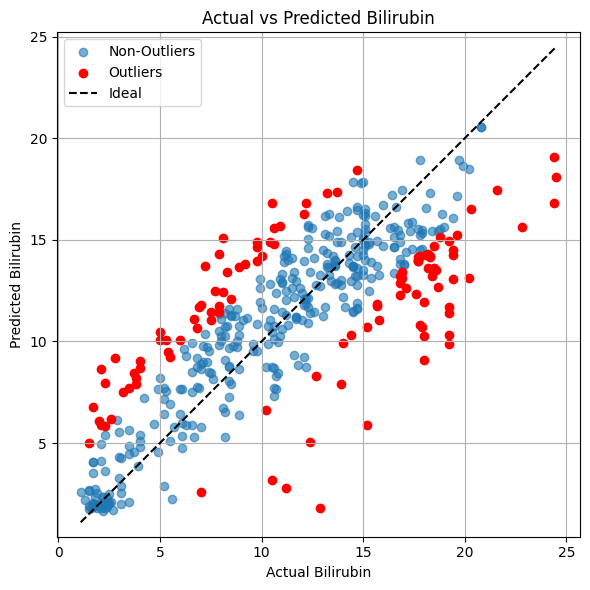

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure NumPy arrays for safe indexing
y_true = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

# Identify outliers based on top 5% absolute error
absolute_error = np.abs(y_true - y_pred)
threshold = np.percentile(absolute_error, 75)
is_outlier = absolute_error > threshold

# Scatter plot: Actual vs Predicted with outliers in red
plt.figure(figsize=(6, 6))
plt.scatter(y_true[~is_outlier], y_pred[~is_outlier], label="Non-Outliers", alpha=0.6)
plt.scatter(y_true[is_outlier], y_pred[is_outlier], color="red", label="Outliers")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label="Ideal")
plt.xlabel("Actual Bilirubin")
plt.ylabel("Predicted Bilirubin")
plt.title("Actual vs Predicted Bilirubin")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

# Filter non-outliers
y_true_filtered = y_true[~is_outlier]
y_pred_filtered = y_pred[~is_outlier]

# Compute new metrics
filtered_mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
filtered_r2 = r2_score(y_true_filtered, y_pred_filtered)

print(f"Filtered MAE (non-outliers): {filtered_mae:.3f}")
print(f"Filtered R² (non-outliers): {filtered_r2:.3f}")


Filtered MAE (non-outliers): 1.470
Filtered R² (non-outliers): 0.873


In [35]:
# Get predictions for the full dataset
all_preds = model.predict([rgb_features_reshaped, hsv_features_reshaped])
residuals = np.abs(y - all_preds.flatten())

# Determine top 5% threshold
threshold = np.percentile(residuals, 75)

# Keep only non-outliers
non_outlier_indices = np.where(residuals <= threshold)[0]

# Filter data
rgb_filtered = rgb_features_reshaped[non_outlier_indices]
hsv_filtered = hsv_features_reshaped[non_outlier_indices]
labels_filtered = y[non_outlier_indices]

print("Filtered data shape:", rgb_filtered.shape)


70/70 [==============================] - 0s 5ms/step
Filtered data shape: (1676, 24, 1)


In [22]:
from sklearn.model_selection import train_test_split

rgb_train, rgb_test, hsv_train, hsv_test, y_train, y_test = train_test_split(
    rgb_filtered, hsv_filtered, labels_filtered, test_size=0.2, random_state=42)


In [24]:
# Build the model again (reuse your `build_rgb_hsv_concat_model`)
input_shape = rgb_train.shape[1:]
model = build_dual_branch_1dcnn(input_shape)

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
34/34 [==============================] - 2s 13ms/step - loss: 9.9507 - mae: 10.4481 - root_mean_squared_error: 11.5675 - val_loss: 8.3753 - val_mae: 8.8546 - val_root_mean_squared_error: 10.1811 - lr: 1.0000e-04
Epoch 2/150
34/34 [==============================] - 0s 7ms/step - loss: 6.4716 - mae: 6.9600 - root_mean_squared_error: 8.1583 - val_loss: 3.7840 - val_mae: 4.2591 - val_root_mean_squared_error: 5.4299 - lr: 1.0000e-04
Epoch 3/150
34/34 [==============================] - 0s 7ms/step - loss: 3.8864 - mae: 4.3644 - root_mean_squared_error: 5.3163 - val_loss: 3.5520 - val_mae: 4.0242 - val_root_mean_squared_error: 4.9849 - lr: 1.0000e-04
Epoch 4/150
34/34 [==============================] - 0s 6ms/step - loss: 3.6161 - mae: 4.0906 - root_mean_squared_error: 5.0177 - val_loss: 3.4399 - val_mae: 3.9148 - val_root_mean_squared_error: 4.8707 - lr: 1.0000e-04
Epoch 5/150
34/34 [==============================] - 0s 7ms/step - loss: 3.5456 - mae: 4.0255 - root_mean_squared_er

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict([rgb_test, hsv_test]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

11/11 [==============================] - 0s 4ms/step

Test Results:
RMSE: 1.80
MAE: 1.47
R²: 0.86
